In [12]:
import pandas as pd
import numpy as np
import os

In [13]:
# load a csv called data.csv with the separation character ','
geo_data = pd.read_csv('raw_data/geo_eth.csv', sep=',')
cons_data = pd.read_csv('raw_data/cons_eth.csv', sep=',')
geo_nig_data = pd.read_csv('raw_data/geo_nig.csv', sep=',')
cons_nig_data = pd.read_csv('raw_data/cons_nig.csv', sep=',')

In [14]:
geo_nig_data.head()

,zone,state,sector,lga,ea,hhid,dist_road2,dist_popcenter2,dist_market,dist_border2,...,evimax_avg,grn_avg,sen_avg,h2015_eviarea,h2015_evimax,h2015_grn,h2015_sen,LAT_DD_MOD,LON_DD_MOD,distY1Y3
0,4.0,1.0,1.0,115.0,670.0,10001,0.9,3.6,48.6,532.6,...,0.5014,104,334,48.7,0.5166,98,332,5.535456,7.531536,NaN
1,4.0,1.0,1.0,115.0,670.0,10002,1.0,3.6,48.7,532.6,...,0.5014,104,334,48.7,0.5166,98,332,5.535456,7.531536,NaN
2,4.0,1.0,1.0,115.0,670.0,10003,0.9,3.7,48.6,532.7,...,0.5014,104,334,48.7,0.5166,98,332,5.535456,7.531536,NaN
3,4.0,1.0,1.0,115.0,670.0,10004,0.7,3.8,48.4,532.8,...,0.5014,104,334,48.7,0.5166,98,332,5.535456,7.531536,NaN
4,4.0,1.0,1.0,115.0,670.0,10005,1.8,3.7,44.9,529.9,...,0.5014,104,334,48.7,0.5166,98,332,5.535456,7.531536,NaN


In [15]:
cons_data.head()

,household_id,household_id2,ea_id,ea_id2,saq01,rural,pw_w3,adulteq,hh_size,no_conv,no_cons,food_cons_ann,nonfood_cons_ann,educ_cons_ann,total_cons_ann,price_index_hce,nom_totcons_aeq,cons_quint
0,1010101601002,10101088801601002,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,1970.800049,1013.0,0.0,2983.800049,1.034,4032.162109,2.0
1,1010101601017,10101088801601017,1010101601,10101088801601,1,1,2897.155029,7.21,9,0,0,7883.200195,5337.0,358.0,13578.200195,1.034,1883.245483,1.0
2,1010101601034,10101088801601034,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,8958.444458,322.0,0.0,9280.444336,1.034,12541.140625,5.0
3,1010101601049,10101088801601049,1010101601,10101088801601,1,1,2897.155029,2.50,3,0,0,9594.000000,1630.0,480.0,11704.000000,1.034,4681.600098,3.0
4,1010101601064,10101088801601064,1010101601,10101088801601,1,1,2897.155029,1.58,2,0,0,11702.888916,3272.0,0.0,14974.888672,1.034,9477.778320,5.0


In [16]:
COUNTRIES_DIR = os.path.join("..", 'data', 'countries')

In [17]:
def process_ethiopia():

    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household

    lat_col = 'lat_dd_mod'
    lon_col = 'lon_dd_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 7.882
   
    # for file in [consumption_file, geovariables_file]:
    #     assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df = cons_data
    df['cons_ph'] = df[consumption_pc_col] * df[hhsize_col]
    df['pph'] = df[hhsize_col]
    df['cons_ph'] = df['cons_ph'] / ppp / 365
    df = df[['household_id2', 'cons_ph', 'pph']]

    df_geo = geo_data
    df_cords = df_geo[['household_id2', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id2')
    df_combined.drop(['household_id2'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
    
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

def process_nigeria():

    consumption_pc_col = 'totcons' # per capita
    hhsize_col = 'hhsize' # people in household
    lat_col = 'LAT_DD_MOD'
    lon_col = 'LON_DD_MOD'

    # purchasing power parity for nigeria in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=NG)
    ppp = 95.255
    
    
    df = cons_nig_data
    df['cons_ph'] = df[consumption_pc_col] * df[hhsize_col]
    df['pph'] = df[hhsize_col]
    df['cons_ph'] = df['cons_ph'] / ppp / 365
    df = df[['hhid', 'cons_ph', 'pph']]

    df_geo = geo_nig_data
    df_cords = df_geo[['hhid', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='hhid')
    df_combined.drop(['hhid'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
    
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    df_clusters['country'] = 'ng'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [22]:
data = process_ethiopia()

/tmp/ipykernel_191200/3879188611.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)


In [23]:
data_nig = process_nigeria()

/tmp/ipykernel_191200/3879188611.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)


In [24]:
data_nig.head()

,country,cluster_lat,cluster_lon,cons_pc
0,ng,4.315786,6.268753,4.317717
1,ng,4.328719,6.308172,4.880711
2,ng,4.398427,7.183962,8.767258
3,ng,4.425192,7.166935,10.774504
4,ng,4.619377,7.684946,5.191333


In [25]:
data.head(3)

,country,cluster_lat,cluster_lon,cons_pc
0,eth,3.455701,39.515994,14.854634
1,eth,3.549937,39.184234,14.312022
2,eth,3.864243,39.101366,12.470145


In [26]:
import math
def create_space(lat, lon, s=10):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    return lat - v, lon - v, lat + v, lon + v
    

In [27]:
import rasterio

url_image = "raw_data/picture.tif"
with rasterio.open(url_image) as src:
    image_data = src.read(1)  
    transform = src.transform
    tif_array = np.squeeze(image_data)



In [28]:

def custom_rasterio_open(max_lon, max_lat):
    xmaxPixel, yminPixel = ~transform * (max_lon, max_lat)
    xmaxPixel, yminPixel = int(xmaxPixel), int(yminPixel)
    return xmaxPixel, yminPixel


In [29]:
def add_nightlights(df, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_nightlights = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = custom_rasterio_open(min_lon, min_lat)
        xmaxPixel, yminPixel = custom_rasterio_open(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_nightlights.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    df['nightlights'] = cluster_nightlights

In [30]:
add_nightlights(data, tif_array)

In [31]:
add_nightlights(data_nig, tif_array)

In [32]:
data['nightlights'].mean()

0.66762424

In [33]:
data_nig['nightlights'].mean()

1.7455132

In [34]:
import random
RANDOM_SEED = 7

def generate_download_locations(df, ipc=50):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'nightlights': [] }
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['nightlights'].append(r.nightlights)
        
    return pd.DataFrame.from_dict(df_download)

In [35]:
df_eth_download = generate_download_locations(data)

In [36]:
df_eth_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,3.410784802784024_39.47107816189403_3.45570056...,3.410785,39.471078,3.455701,39.515994,14.854634,0.0
1,3.4257567241860163_39.47107816189403_3.4557005...,3.425757,39.471078,3.455701,39.515994,14.854634,0.0
2,3.440728645588008_39.47107816189403_3.45570056...,3.440729,39.471078,3.455701,39.515994,14.854634,0.0
3,3.45570056699_39.47107816189403_3.45570056699_...,3.455701,39.471078,3.455701,39.515994,14.854634,0.0
4,3.470672488391992_39.47107816189403_3.45570056...,3.470672,39.471078,3.455701,39.515994,14.854634,0.0


In [37]:
df_nig_download =  generate_download_locations(data_nig)

In [38]:
df_nig_download["country"] = "nig"
df_eth_download["country"] = "eth"
df_potential_download = pd.concat([ df_eth_download, df_nig_download], axis=0)
df_potential_download.reset_index(drop=True, inplace=True)

In [39]:
def drop_0s(df, fr=0.1):
    """
        Solves for d:
            (c_z - d)/(n - d) = fr
        Where d = rows to drop, c_z = num rows with zero nightlights, n = num rows, fr = frac remaining
        
        Yields:
        d = (c_z - n*fr) / (1 - fr)
    """
    np.random.seed(RANDOM_SEED)
    c_z = (df['nightlights']==0).sum()
    n = len(df)
    assert c_z / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_z - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    zero_df = df[df['nightlights']==0]
    zero_clusters = zero_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(zero_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster with 0 nightlights')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in zero_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= 10, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
    
    # this is how you do it purely randomly but some clusters might get wiped out
    # z_inds = np.argwhere(df['nightlights'].values == 0).reshape(-1)
    # drop_inds = np.random.choice(z_inds, d, replace=False)
    return df.drop(drop_inds).reset_index(drop=True)

def drop_in_range(df, lower=0, upper=2, fr=0.25):
    """
        Very similar to drop_0s calculation, but more generalized. Lower and upper are inclusive.
    """
    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['nightlights']) & (df['nightlights'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} rows in the given range')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    select_clusters = select_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(select_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster in the given range')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in select_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= 10, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
        
    return df.drop(drop_inds).reset_index(drop=True)

In [40]:
df_mod_download = drop_0s(df_potential_download, fr=0.1)

dropping: 12961
Need to drop 36 per cluster with 0 nightlights


In [41]:
df_mod_download = drop_in_range(df_mod_download, lower=0.001, upper=3, fr=0.4)

dropping: 25381
Need to drop 37 per cluster in the given range


In [42]:
df_mod_download = drop_0s(df_mod_download, fr=0.2)

dropping: 761
Need to drop 2 per cluster with 0 nightlights


In [43]:
from sklearn.mixture import GaussianMixture as GMM
X = df_mod_download['nightlights'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(df_mod_download['nightlights'].values.reshape(-1,1))

In [44]:
(labels==0).mean(), (labels==1).mean(), (labels==2).mean()

(0.9880314055917273, 0.0023937188816545384, 0.009574875526618154)

In [45]:
label0_max = df_mod_download['nightlights'][labels==0].max()
label1_max = df_mod_download['nightlights'][labels==1].max()
label2_max = df_mod_download['nightlights'][labels==2].max()
label0_max, label1_max, label2_max

(17.48365020751953, 120.02664947509766, 52.253047943115234)

In [46]:
label0_max = 0.05
label1_max = 5
label2_max = 70

def query_df(df, lower, upper):
    return df[((lower <= df['nightlights']) & (df['nightlights'] < upper))]

print(len(query_df(df_mod_download, 0, label0_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label0_max, label1_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label1_max, label2_max)) / len(df_mod_download))

0.45911528150134046
0.3422060513213328
0.19628494829567217


In [47]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['nightlights_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['nightlights_bin'].loc[df['nightlights'] <= cutoff] = label

df_download = df_mod_download.copy()
create_nightlights_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

/tmp/ipykernel_191200/4028382644.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['nightlights_bin'].loc[df['nightlights'] <= cutoff] = label
/tmp/ipykernel_191200/4028382644.py:7: SettingWithCopyWarning: 
A value is trying to be set o

In [48]:
df_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights,country,nightlights_bin
0,3.45570056699_39.47107816189403_3.45570056699_...,3.455701,39.471078,3.455701,39.515994,14.854634,0.0,eth,0
1,3.470672488391992_39.47107816189403_3.45570056...,3.470672,39.471078,3.455701,39.515994,14.854634,0.0,eth,0
2,3.4257567241860163_39.48605008329602_3.4557005...,3.425757,39.486050,3.455701,39.515994,14.854634,0.0,eth,0
3,3.410784802784024_39.50102200469801_3.45570056...,3.410785,39.501022,3.455701,39.515994,14.854634,0.0,eth,0
4,3.485644409793984_39.50102200469801_3.45570056...,3.485644,39.501022,3.455701,39.515994,14.854634,0.0,eth,0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


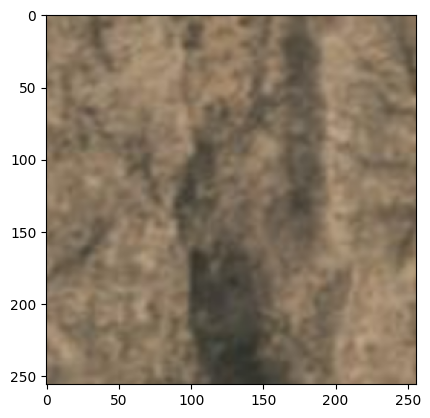

In [62]:
from utils import PlanetDownloader
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

client = PlanetDownloader("***REMOVED***")
X = []
# iterate between df df_download and donwload images
for i, row in df_download.iterrows():
    lat = row['image_lat']
    lon = row['image_lon']
    img = client.download_image(lat, lon, 2015, 1, 2016, 12)
    if img is not None:
        X.append(img)
        break
    
# show X
